In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import pandas as pd
import os

# Đường dẫn đến thư mục chứa các file CSV
folder_path = '/kaggle/input/data-high-rate/hour'

# Danh sách chứa tất cả các DataFrame
all_dataframes = []

# Lặp qua tất cả các file CSV trong thư mục
# for file_name in os.listdir(folder_path):
#     if file_name.endswith('.csv'):
#         file_path = os.path.join(folder_path, file_name)
#         df = pd.read_csv(file_path)
#         all_dataframes.append(df)

# daily
for folder in os.listdir(folder_path):
    if folder == "merge":
        continue
    for file_name in os.listdir(os.path.join(folder_path,folder)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, folder,file_name)
            df = pd.read_csv(file_path)
            all_dataframes.append(df)
# print(all_dataframes)

# Gộp tất cả các DataFrame lại
merged_df = pd.concat(all_dataframes, ignore_index=True)
# Lưu DataFrame gộp vào một file CSV mới
merged_df.to_csv('merged_file.csv', index=False)

# Đọc dữ liệu từ tệp CSV
file_path = "/kaggle/working/merged_file.csv"
df = pd.read_csv(file_path)

# Lựa chọn các đặc trưng: thời gian, nhiệt độ, kinh độ, vĩ độ
# Chuyển đổi cột thời gian thành số (giả sử là số giờ từ đầu ngày)
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour

# Chuyển đổi cột thời gian thành định dạng datetime
df['time'] = pd.to_datetime(df['time'])

# Chọn một ngày mốc
epoch = pd.Timestamp('2022-01-01')

# Tính toán số ngày từ ngày mốc và cộng thêm số giờ
df['time_numeric'] = (df['time'] - epoch).dt.days + df['time'].dt.hour/24
df['t2m'] +=273
df['longitude'] += 100
df["latitude"] += 100
# Chọn các cột đặc trưng và nhãn
features = df[['t2m']].values
# features = df['t2m'].values.reshape(-1, 1)
# labels = df['Fault_Label'].values  # Hoặc 'Fault_Type'
labels = df['Fault_Type'].values  # Hoặc 'Fault_Label'
# print(features[:30])
# print(df['t2m'])
# # Chuẩn hóa dữ liệu
scaler = StandardScaler()
# scaler=MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(features)
# # print(features[:30])
sequence_length = 48
# sequences = []
# labels = []
features = features.reshape(-1)
# # Iterate through the DataFrame in steps of `sequence_length` to avoid overlap
# for i in range(0, len(df), sequence_length):
#     # Check if there are enough data points left for a full sequence
#     if i + sequence_length <= len(df):
#         # Create a sequence of 5 consecutive data points as a 2D array (5x4)
#         sequence = df.iloc[i:i+sequence_length][["t2m"]].values
#         sequences.append(sequence)
        
#         # Determine the label based on Fault_Label in the 5-point sequence
#         label = 1 if df.iloc[i:i+sequence_length]["Fault_Label"].max() == 1 else 0
#         labels.append(label)

# # Convert to NumPy arrays for easier handling
# X_seq = np.array(sequences)
# y_seq = np.array(labels)


# features = features.reshape(-1)
num_samples = len(features) - sequence_length + 1

#Non - overlap
X_seq = np.array([features[i*sequence_length:(i+1)*sequence_length] for i in range(num_samples//sequence_length)])
y_seq = np.array([max(labels[i*sequence_length:(i+1)*sequence_length]) for i in range(num_samples//sequence_length)])

#Overlap
# X_seq = np.array([features[i:i+sequence_length] for i in range(num_samples)])
# y_seq = np.array([max(labels[i:i+sequence_length]) for i in range(num_samples)])
# y_seq = np.expand_dims(y_seq,axis=1)

# # Splitting the data
split_ratio = 0.1
split_index = int(num_samples//sequence_length * split_ratio)
# X_train, X_test = X_seq[split_index:], X_seq[:split_index]
# y_train, y_test = y_seq[split_index:], y_seq[:split_index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Converting to Tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)


# Creating TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify batch shape
for X_batch, y_batch in train_loader:
    print("Feature batch:", X_batch.shape)  # Should output [64, 5, 4]
    print("Label batch:", y_batch.shape)    # Should output [64]
    # print(X_batch)
    break

Feature batch: torch.Size([64, 48])
Label batch: torch.Size([64])


In [13]:
len(train_loader), len(val_loader), len(test_loader)

(43, 3, 3)

In [29]:
len(y_train_tensor)

8211

In [27]:
X_seq.shape

(3040, 72)

In [23]:
len(y_test_tensor[y_test_tensor == 0])

2904

In [119]:
for X_batch, y_batch in test_loader:
    print("Feature batch:", X_batch.shape)  # Should output [64, 5, 4]
    print("Label batch:", y_batch.shape)    # Should output [64]
    print(y_batch)
    break

Feature batch: torch.Size([1, 5])
Label batch: torch.Size([1])
tensor([0])


In [28]:
idx = 0
for X_batch, y_batch in train_loader:
    if idx == 1:
        print("Feature batch:", X_batch)
        print("Label batch:", y_batch)
        print(y_batch.shape)
        break
    idx +=1

Feature batch: tensor([[-0.1213,  0.3206,  0.8189,  1.2644,  1.4409,  1.6575,  1.6548,  1.5200,
          1.3435,  1.0766,  0.6729,  0.2983,  0.1522,  0.0723,  0.0036, -0.0629,
         -0.1206, -0.1968, -0.2810, -0.3790, -0.4572, -0.5115, -0.5565, -0.5853]])
Label batch: tensor([0])
torch.Size([1])


In [ ]:
# import torch
# import torch.nn as nn
# from tqdm import tqdm

# # Định nghĩa lớp RBM
# class RBM(nn.Module):
#     def __init__(self, visible_units, hidden_units, learning_rate=0.00005, device='cpu'):
#         super(RBM, self).__init__()
#         self.visible_units = visible_units
#         self.hidden_units = hidden_units
#         self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.001)
#         self.h_bias = nn.Parameter(torch.zeros(hidden_units))
#         self.v_bias = nn.Parameter(torch.zeros(visible_units))
#         self.learning_rate = learning_rate
#         self.device = device
#         self.to(device)  # Send model parameters to the specified device

#     def forward(self, v):
#         v = v.to(self.device)  # Ensure input is on the correct device
#         h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
#         # print("h_prob",h_prob)
#         h_sample = torch.bernoulli(h_prob)
#         return h_sample

#     def backward(self, h):
#         h = h.to(self.device)  # Ensure input is on the correct device
#         v_prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
#         # print("v_prob",v_prob)
#         v_sample = torch.bernoulli(v_prob)
#         return v_sample

#     def train_rbm(self, dataloader, epochs=100):
#         for epoch in tqdm(range(epochs), desc="Training RBM"):
#             idx = 0
#             for X_batch,y_batch in dataloader:
#                 v = X_batch.to(self.device)
#                 h = self.forward(v)
#                 v_reconstructed = self.backward(h)
#                 # Tính gradient và cập nhật trọng số
#                 positive_grad = torch.matmul(h.t(), v)
#                 negative_grad = torch.matmul(h.t(), v_reconstructed)
#                 # print(positive_grad, negative_grad)
#                 # print("Before",self.W.data)
#                 # print(self.learning_rate * torch.sum(v - v_reconstructed, dim=0))
#                 self.W.data += self.learning_rate * (positive_grad - negative_grad)
#                 self.v_bias.data += self.learning_rate * torch.sum(v - v_reconstructed, dim=0)
#                 self.h_bias.data += self.learning_rate * torch.sum(h - h, dim=0)
#                 # print("After",self.W.data)
#                 # if(idx == 1 or idx == 5):
#                 #     print(h)
#                 # idx +=1
                



In [47]:
# # Định nghĩa mô hình DBN
# class DBN(nn.Module):
#     def __init__(self, input_size, k, l,device ='cpu'):
#         super(DBN, self).__init__()
#         self.device = device
#         self.rbm1 = RBM(input_size, 2 * k - 1,device =device)
#         self.rbm2 = RBM(2 * k - 1, 2 * k - 1,device =device)
#         self.bp_model = nn.Sequential(
#             nn.Linear(2 * k - 1, l),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         x = self.rbm1.forward(x)
#         x = self.rbm2.forward(x)
#         x = self.bp_model(x)
#         return x

In [48]:
# # Cấu hình mô hình
# k = X_train.shape[1]  # Số đặc trưng trong dữ liệu
# l = 2  # Số lượng lớp Softmax neurons
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# dbn = DBN(input_size=k, k=k, l=l,device=device).to(device)

# # Hàm mất mát và bộ tối ưu
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.SGD(dbn.parameters(), lr=0.0005)

# # Huấn luyện mô hình
# epochs_rbm = 50  # Số epoch cho RBM
# epochs_bp = 50   # Số epoch cho Backpropagation
# batch_size = 32

# # Huấn luyện RBM1
# dbn.rbm1.train_rbm(train_loader, epochs=epochs_rbm)

# # Lấy đầu ra của RBM1 để huấn luyện RBM2
# hidden_outputs = []

# with torch.no_grad():
#     idx = 0
#     for X_batch,y_batch in train_loader:
#         # print("down")
#         v = X_batch.to(dbn.rbm1.device)  # Extract data and move to the device
#         h = dbn.rbm1.forward(v)
#         if idx == len(train_loader)-1:
#              print("h",h)
#         idx +=1
        
#         hidden_outputs.append(h)
        

# # Concatenate all hidden outputs into a single tensor for RBM2 training
# hidden_outputs = torch.cat(hidden_outputs, dim=0)

# # Create a DataLoader for RBM2 training
# hidden_dataset = TensorDataset(hidden_outputs,torch.zeros(hidden_outputs.shape[0]))
# hidden_loader = DataLoader(hidden_dataset, batch_size=64, shuffle=False)
# # Huấn luyện RBM2
# dbn.rbm2.train_rbm(hidden_loader, epochs=epochs_rbm)

# # Huấn luyện mô hình DBN
# for epoch in range(epochs_bp):
#     for X_batch, y_batch in train_loader:
#         # Forward pass
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)
#         outputs = dbn(X_batch)
#         # print(outputs.shape)
#         # print(y_batch.shape)
#         loss = criterion(outputs, y_batch.squeeze())

#         # Backward pass và cập nhật trọng số
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         # break
    
#     print(f'Epoch {epoch+1}/{epochs_bp}, Loss: {loss.item()}')
#     # break

cuda


TypeError: RBM.__init__() got an unexpected keyword argument 'device'

In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# # Ensure the model is in evaluation mode
# dbn.eval()

# # Initialize lists to collect predictions and labels for overall metrics
# all_y_pred_classes = []
# all_y_test_classes = []

# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         # Move inputs and labels to the appropriate device
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
#         # Get predictions
#         y_pred = dbn(X_batch)
#         y_pred_classes = torch.argmax(y_pred, dim=1)
        
#         # Calculate accuracy for this batch
#         accuracy = torch.sum(y_pred_classes == y_batch).item() / len(y_batch)
#         # print(f'Batch Accuracy: {accuracy * 100:.2f}%')
        
#         # Collect predictions and true labels for overall metrics
#         all_y_pred_classes.extend(y_pred_classes.cpu().numpy())
#         all_y_test_classes.extend(y_batch.cpu().numpy())

# # Calculate overall precision, recall, and F1-score
# precision = precision_score(all_y_test_classes, all_y_pred_classes, average='weighted')
# recall = recall_score(all_y_test_classes, all_y_pred_classes, average='weighted')
# f1 = f1_score(all_y_test_classes, all_y_pred_classes, average='weighted')

# print(f'Overall Precision: {precision:.2f}')
# print(f'Overall Recall: {recall:.2f}')
# print(f'Overall F1 Score: {f1:.2f}')


### New RBm trainning

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F

# class RBM(nn.Module):
#     def __init__(self, n_visible, n_hidden):
#         super(RBM, self).__init__()
#         self.n_visible = n_visible
#         self.n_hidden = n_hidden
        
#         # Weight and bias initialization
#         self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
#         self.h_bias = nn.Parameter(torch.zeros(n_hidden))
#         self.v_bias = nn.Parameter(torch.zeros(n_visible))
    
#     def sample_from_p(self, p):
#         """Sample a binary state based on probabilities p."""
#         return F.relu(p - torch.rand(p.size(), device=p.device))
    
#     def forward(self, v):
#         """Perform one step of Gibbs sampling: visible to hidden to visible."""
#         h_prob = torch.relu(torch.mm(v, self.W.t())+ self.h_bias)
#         # print(h_prob)
#         h_sample = self.sample_from_p(h_prob)
        
#         v_prob = torch.relu(torch.mm(h_sample, self.W)+ self.v_bias)
#         v_sample = self.sample_from_p(v_prob)
#         return v_sample, h_prob, h_sample
    
#     def free_energy(self, v):
#         """Calculate the free energy for a given visible layer v."""
#         vbias_term = v.mv(self.v_bias)
#         wx_b = F.relu(torch.mm(v, self.W.t()) + self.h_bias)
#         hidden_term = torch.sum(F.softplus(wx_b), dim=1)
#         return -vbias_term - hidden_term

# def train_rbm(rbm, data_loader, n_epochs=10, learning_rate=0.001, k=1,device ='cpu'):
#     """Train an RBM using contrastive divergence."""
#     optimizer = optim.SGD(rbm.parameters(), lr=learning_rate)
#     for epoch in range(n_epochs):
#         epoch_loss = 0
#         idx =0
    
#         for batch in data_loader:
#             v, _ = batch
#             v = v.view(-1, rbm.n_visible) # Flatten the input

#             v = v.to(device)
#             # Positive phase
            
#             v_sample, h_prob, h_sample = rbm(v)
            
#             for _ in range(k):
#                 v_sample, h_prob, h_sample = rbm(v_sample)
            
#             # print(v_sample)
            
#             # break
#             # Update weights and biases
#             positive_grad = torch.mm(h_prob.t(), v)  # Hoán đổi thứ tự ma trận
#             negative_grad = torch.mm(h_sample.t(),v_sample)  # Hoán đổi thứ tự ma trận
#             # print(negative_grad)
#             # break
#             # if idx == len(data_loader) -1:
#             #     print(v)
#             #     print(v_sample)
#             #     print(h)
#             #     print(h_sample)
#             optimizer.zero_grad()
#             rbm.W.grad = (positive_grad - negative_grad) / v.size(0)
#             rbm.v_bias.grad =  torch.sum(v - v_sample, dim=0) / v.size(0)
#             rbm.h_bias.grad = torch.sum(h_prob - h_sample, dim=0) / v.size(0)
#             optimizer.step()
#             epoch_loss += torch.mean(rbm.free_energy(v) - rbm.free_energy(v_sample))
#             idx +=1
#         print(rbm.W)
    
#         print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss.item()}")

# # Example usage:
# # Initialize the RBM and data loader
# n_visible = 4  # Example for MNIST (28*28)
# n_hidden = 2 * n_visible -1   # Number of hidden units
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# rbm1 = RBM(n_visible, n_hidden)
# rbm1.to(device)
# rbm2 = RBM(n_hidden, n_hidden)

# # Assuming data_loader is defined and provides batches of MNIST data
# train_rbm(rbm1, train_loader, n_epochs=20, learning_rate=0.005, k=1,device=device)

# hidden_outputs = []
# with torch.no_grad():
#     for batch in train_loader:
#         v, _ = batch
#         v = v.view(-1, rbm1.n_visible) # Flatten the input
#         v = v.to(device)
            
#         v_sample, h_prob, h_sample = rbm1(v)
        
#         hidden_outputs.append(h_prob)
# hidden_outputs = torch.cat(hidden_outputs, dim=0)

# # Create a DataLoader for RBM2 training
# hidden_dataset = TensorDataset(hidden_outputs,torch.zeros(hidden_outputs.shape[0]))
# hidden_loader = DataLoader(hidden_dataset, batch_size=64, shuffle=False)
# rbm2.to(device)
# train_rbm(rbm2, hidden_loader, n_epochs=20, learning_rate=0.005, k=1,device=device)

### RBM with 4 feauture

In [50]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import torch.nn.functional as F
# from tqdm import trange

# class RBM(nn.Module):
#     def __init__(self, n_visible, n_hidden, lr=0.001, epochs=5, mode='bernoulli', batch_size=32, k=3, optimizer='adam', gpu=False, savefile=None, early_stopping_patience=5):
#         super(RBM, self).__init__()
#         self.mode = mode  # 'bernoulli' or 'gaussian' RBM
#         self.n_hidden = n_hidden
#         self.n_visible = n_visible
#         self.lr = lr
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.k = k
#         self.optimizer = optimizer
#         self.beta_1 = 0.9
#         self.beta_2 = 0.999
#         self.epsilon = 1e-7
#         self.m = [0, 0, 0]
#         self.v = [0, 0, 0]
#         self.savefile = savefile
#         self.early_stopping_patience = early_stopping_patience
#         self.stagnation = 0
#         self.previous_loss = float('inf')
#         self.progress = []

#         # Set device to GPU if available and specified
#         self.device = torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")

#         # Initialize weights and biases
#         std = 4 * np.sqrt(6. / (self.n_visible + self.n_hidden))
#         self.W = torch.normal(mean=0, std=std, size=(self.n_hidden, self.n_visible), device=self.device)
#         self.vb = torch.zeros(size=(1,self.n_visible), device=self.device)
#         self.hb = torch.zeros(size=(1,self.n_hidden), device=self.device)

#     def sample_h(self, x):
#         wx = torch.bmm(self.W.unsqueeze(0).repeat(x.size(0), 1, 1),x)
#         activation = wx + self.hb.unsqueeze(-1)
#         p_h_given_v = torch.sigmoid(activation)
#         if self.mode == 'bernoulli':
#             return p_h_given_v, torch.bernoulli(p_h_given_v)
#         else:
#             random_noise = torch.normal(mean=0, std=1, size=p_h_given_v.shape, device=self.device)
#             return_value = p_h_given_v +random_nose
#             del random_noise
#             return p_h_given_v, return_value

#     def sample_v(self, y):
        
#         wy = torch.bmm(self.W.t().unsqueeze(0).repeat(y.size(0), 1, 1),y)
#         activation = wy + self.vb.unsqueeze(-1)
#         p_v_given_h = torch.sigmoid(activation)
#         del wy,activation
#         if self.mode == 'bernoulli':
#             return p_v_given_h, torch.bernoulli(p_v_given_h)
#         else:
#             return p_v_given_h, p_v_given_h + torch.normal(mean=0, std=1, size=p_v_given_h.shape, device=self.device)

#     def adam(self, g, epoch, index):
#         self.m[index] = self.beta_1 * self.m[index] + (1 - self.beta_1) * g
#         self.v[index] = self.beta_2 * self.v[index] + (1 - self.beta_2) * torch.pow(g, 2)

#         m_hat = self.m[index] / (1 - np.power(self.beta_1, epoch))
#         v_hat = self.v[index] / (1 - np.power(self.beta_2, epoch))
#         return m_hat / (torch.sqrt(v_hat) + self.epsilon)

#     def update(self, v0, vk, ph0, phk, epoch):
#         dW = (torch.bmm(ph0,v0.transpose(1, 2)) - torch.bmm(phk,vk.transpose(1, 2))).sum(dim=0)
#         dvb = torch.sum(v0 - vk, dim=0).sum(dim=-1)
#         dhb = torch.sum(ph0 - phk, dim=0).sum(dim=-1)

#         if self.optimizer == 'adam':
#             dW = self.adam(dW, epoch, 0)
#             dvb = self.adam(dvb, epoch, 1)
#             dhb = self.adam(dhb, epoch, 2)
            
#         with torch.no_grad():
#             self.W.add_(self.lr * dW) 
#             self.vb.add_(self.lr * dvb)  
#             self.hb.add_(self.lr * dhb)
        

#     # def train(self, dataset):
#     #     # Start training progress bar
#     #     learning = trange(self.epochs, desc="Starting...")
        
#     #     for epoch in learning:
#     #         train_loss = 0
#     #         counter = 0
            
#     #         # Loop through dataset in batches
#     #         for batch_start_index in range(0, dataset.shape[0] - self.batch_size, self.batch_size):
#     #             # Extract batch and transfer to device
#     #             v0 = dataset[batch_start_index:batch_start_index + self.batch_size].to(self.device)
#     #             vk = v0.clone()  # Initialize vk with the same values as v0
                
#     #             # Positive phase
#     #             ph0, _ = self.sample_h(v0)
                
#     #             # Gibbs sampling (k-steps)
#     #             for _ in range(self.k):
#     #                 _, hk = self.sample_h(vk)
#     #                 _, vk = self.sample_v(hk)
                
#     #             # Negative phase
#     #             phk, _ = self.sample_h(vk)
                
#     #             # Update weights and biases
#     #             self.update(v0, vk, ph0, phk, epoch + 1)
                
#     #             # Accumulate training loss
#     #             train_loss += torch.mean(torch.abs(v0 - vk)).item()
#     #             counter += 1
            
#     #         # Average loss for the epoch
#     #         avg_loss = train_loss / counter
#     #         self.progress.append(avg_loss)
#     #         learning.set_description(f"Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
#     #         learning.refresh()
            
#     #         # Early stopping logic
#     #         if avg_loss > self.previous_loss and epoch > self.early_stopping_patience:
#     #             self.stagnation += 1
#     #             if self.stagnation >= self.early_stopping_patience:
#     #                 print("Early stopping: Loss not improving.")
#     #                 break
#     #         else:
#     #             self.previous_loss = avg_loss
#     #             self.stagnation = 0
        
#     #     learning.close()

#     def train_new(self, data_loader):
#         learning = trange(self.epochs, desc="Starting...")
#         for epoch in learning:
#             train_loss = 0
#             counter = 0
#             for batch in data_loader:
#                 v, _ = batch
#                 v = v.to(self.device)
#                 # Positive phase
                
#                 ph0, _ = self.sample_h(v)
            
#                 # Gibbs sampling (k-steps)
#                 vk = v
#                 for _ in range(self.k):
#                     _, hk = self.sample_h(vk)
#                     _, vk = self.sample_v(hk)

#                 # Negative phase
#                 phk, _ = self.sample_h(vk)
                
#                 # Update weights and biases
                
#                 self.update(v, vk, ph0, phk, epoch + 1)
                
#                 train_loss += torch.mean(torch.abs(v - vk)).item()
#                 counter += 1
#                 del v, vk, ph0, phk, hk
#                 torch.cuda.empty_cache()
#                 # del tensor  # Delete the tensor
                
#             avg_loss = train_loss / counter
#             self.progress.append(avg_loss)
#             learning.set_description(f"Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
#             learning.refresh()

#             # Early stopping check
#             if avg_loss > self.previous_loss and epoch > self.early_stopping_patience:
#                 self.stagnation += 1
#                 if self.stagnation >= self.early_stopping_patience:
#                     print("Early stopping: Loss is not improving.")
#                     break
#             else:
#                 self.previous_loss = avg_loss
#                 self.stagnation = 0
#         learning.close()

# # Parameters
# n_visible = 5  # Number of visible units
# n_hidden = 2 * n_visible - 1  # Number of hidden units
# epochs = 50
# lr = 0.005
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # Initialize the RBM
# rbm1 = RBM(n_visible, n_hidden, epochs=epochs, mode='bernoulli', lr=lr, optimizer='adam', gpu=True, early_stopping_patience=5)

# # Assume `train_loader` is defined as a DataLoader for the training dataset
# rbm1.train_new(train_loader)


Starting...:   0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: batch2 must be a 3D tensor

In [ ]:
# rbm2 = RBM(n_hidden, n_hidden, epochs=epochs, mode='bernoulli', lr=lr, optimizer='adam', gpu=True, early_stopping_patience=5)

# hidden_outputs = []

# with torch.no_grad():
#     idx = 0
#     for X_batch,y_batch in train_loader:
#         # print("down")
#         v = X_batch.to(device)  # Extract data and move to the device
#         _, h= rbm1.sample_h(v)
#         hidden_outputs.append(h)
        

# # Concatenate all hidden outputs into a single tensor for RBM2 training
# hidden_outputs = torch.cat(hidden_outputs, dim=0)
# hidden_dataset = TensorDataset(hidden_outputs,torch.zeros(hidden_outputs.shape[0]))
# hidden_loader = DataLoader(hidden_dataset, batch_size=64, shuffle=False)

# rbm2.train_new(hidden_loader)

In [ ]:
# class DBN(nn.Module):
#     def __init__(self,k, rbm = [rbm1,rbm2],device ='cpu'):
#         super(DBN, self).__init__()
#         self.device = device
#         self.k = k
#         self.rbm1 = rbm1.to(self.device)
#         self.rbm2 = rbm2.to(self.device)
#         self.flatten = nn.Flatten()
#         self.bp_model = nn.Sequential(
#             nn.Linear((2 * self.k - 1), 5),
#             nn.Softmax(dim=1)
#         )
#         self.rbm1.W = nn.Parameter(self.rbm1.W)
#         self.rbm1.vb = nn.Parameter(self.rbm1.vb)
#         self.rbm1.hb = nn.Parameter(self.rbm1.hb)

#         self.rbm2.W = nn.Parameter(self.rbm2.W)
#         self.rbm2.vb = nn.Parameter(self.rbm2.vb)
#         self.rbm2.hb = nn.Parameter(self.rbm2.hb)

#     def forward(self, x):
#         _,x = self.rbm1.sample_h(x)
#         _,x = self.rbm2.sample_h(x)
#         x = self.flatten(x)
#         x = self.bp_model(x)
#         return x
        
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
#         """
#         :param alpha: Weighting factor for the class imbalance (float).
#         :param gamma: Focusing parameter to reduce the impact of easy examples (float).
#         :param reduction: Specifies the reduction to apply to the output: 'none' | 'mean' | 'sum'.
#         """
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         """
#         :param inputs: Predicted probabilities (logits), shape [batch_size, num_classes].
#         :param targets: Ground truth labels, shape [batch_size].
#         """
#         # Apply softmax to inputs
#         probas = F.softmax(inputs, dim=1)
        
#         # Gather probabilities corresponding to the true class
#         targets_one_hot = F.one_hot(targets, num_classes=probas.size(1)).float()
#         probas = probas.clamp(min=1e-8, max=1.0)  # Avoid log(0) issues
#         pt = (probas * targets_one_hot).sum(dim=1)
        
#         # Compute the Focal Loss
#         focal_loss = -self.alpha * ((1 - pt) ** self.gamma) * torch.log(pt)
        
#         # Apply reduction method
#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         else:  # 'none'
#             return focal_loss


# dbn = DBN(k = 24, rbm =[rbm1,rbm2], device = device).to(device)

# epochs_bp = 20
# criterion = FocalLoss(alpha=1.0, gamma=2.0, reduction='mean').to(device)
# # criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.SGD(dbn.parameters(), lr=0.0005)
# dbn.train()
# for epoch in range(epochs_bp):
#     for X_batch, y_batch in train_loader:
#         # Forward pass
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)
#         outputs = dbn(X_batch)
#         # print(outputs.shape)
#         # print(y_batch.shape)
#         loss = criterion(outputs, y_batch.squeeze())

#         # Backward pass và cập nhật trọng số
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         # break
    
#     print(f'Epoch {epoch+1}/{epochs_bp}, Loss: {loss.item()}')
#     # break


In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# # Ensure the model is in evaluation mode

# # Initialize lists to collect predictions and labels for overall metrics
# all_y_pred_classes = []
# all_y_test_classes = []
# dbn.eval()
# with torch.no_grad():
#     idx = 0
#     for X_batch, y_batch in test_loader:
#         # Move inputs and labels to the appropriate device
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
#         # Get predictions
#         y_pred = dbn(X_batch)
#         y_pred_classes = torch.argmax(y_pred, dim=1)
#         print(y_pred_classes,y_batch)
#         idx +=1
#         if(idx == 4):
#             break
#         # Calculate accuracy for this batch
#         accuracy = torch.sum(y_pred_classes == y_batch).item() / len(y_batch)
#         # print(f'Batch Accuracy: {accuracy * 100:.2f}%')
        
#         # Collect predictions and true labels for overall metrics
#         all_y_pred_classes.extend(y_pred_classes.cpu().numpy())
#         all_y_test_classes.extend(y_batch.cpu().numpy())

# # Calculate overall precision, recall, and F1-score
# precision = precision_score(all_y_test_classes, all_y_pred_classes, average='weighted')
# recall = recall_score(all_y_test_classes, all_y_pred_classes, average='weighted')
# f1 = f1_score(all_y_test_classes, all_y_pred_classes, average='weighted')

# print(f'Overall Precision: {precision:.2f}')
# print(f'Overall Recall: {recall:.2f}')
# print(f'Overall F1 Score: {f1:.2f}')

### RBM with 1 feature

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from tqdm import trange

class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, lr=0.001, epochs=5, mode='bernoulli', batch_size=32, k=3, optimizer='adam', gpu=False, savefile=None, early_stopping_patience=5):
        super(RBM, self).__init__()
        self.mode = mode  # 'bernoulli' or 'gaussian' RBM
        self.n_hidden = n_hidden
        self.n_visible = n_visible
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.k = k
        self.optimizer = optimizer
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.epsilon = 1e-7
        self.m = [0, 0, 0]
        self.v = [0, 0, 0]
        self.savefile = savefile
        self.early_stopping_patience = early_stopping_patience
        self.stagnation = 0
        self.previous_loss = float('inf')
        self.progress = []

        # Set device to GPU if available and specified
        self.device = torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")

        # Initialize weights and biases
        std = 4 * np.sqrt(6. / (self.n_visible + self.n_hidden))
        self.W = torch.normal(mean=0, std=std, size=(self.n_hidden, self.n_visible), device=self.device)
        self.vb = torch.zeros(size=(1,self.n_visible), device=self.device)
        self.hb = torch.zeros(size=(1,self.n_hidden), device=self.device)

    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx - self.hb
        p_h_given_v = torch.relu(activation)
        if self.mode == 'bernoulli':
            return p_h_given_v, torch.bernoulli(p_h_given_v)
        else:
            # random_noise = torch.normal(mean=0, std=1, size=p_h_given_v.shape, device=self.device)
            return_value = p_h_given_v
            # del random_noise
            return p_h_given_v, return_value

    def sample_v(self, y):
        
        wy = torch.mm(y, self.W)
        activation = wy - self.vb
        p_v_given_h =torch.relu(activation)
        if self.mode == 'bernoulli':
            return p_v_given_h, torch.bernoulli(p_v_given_h)
        else:
            return p_v_given_h, p_v_given_h

    def adam(self, g, epoch, index):
        self.m[index] = self.beta_1 * self.m[index] + (1 - self.beta_1) * g
        self.v[index] = self.beta_2 * self.v[index] + (1 - self.beta_2) * torch.pow(g, 2)

        m_hat = self.m[index] / (1 - np.power(self.beta_1, epoch))
        v_hat = self.v[index] / (1 - np.power(self.beta_2, epoch))
        return m_hat / (torch.sqrt(v_hat) + self.epsilon)

    def forward(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx - self.hb
        p_h_given_v = torch.relu(activation)
        return p_h_given_v

    def update(self, v0, vk, ph0, phk, epoch):
        dW = (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        dvb = torch.sum((v0 - vk), 0)
        dhb = torch.sum((ph0 - phk), 0)

        if self.optimizer == 'adam':
            dW = self.adam(dW, epoch, 0)
            dvb = self.adam(dvb, epoch, 1)
            dhb = self.adam(dhb, epoch, 2)
            
        with torch.no_grad():
            self.W.add_(self.lr * dW) 
            self.vb.add_(self.lr * dvb)  
            self.hb.add_(self.lr * dhb)

    def train_new(self, data_loader):
        learning = trange(self.epochs, desc="Starting...")
        for epoch in learning:
            train_loss = 0
            counter = 0
            for batch in data_loader:
                v, _ = batch
                v = v.to(self.device)
                # Positive phase

                ph0, _ = self.sample_h(v)
            
                # Gibbs sampling (k-steps)
                vk = v
                for _ in range(self.k):
                    _, hk = self.sample_h(vk)
                    _, vk = self.sample_v(hk)

                # Negative phase
                phk, _ = self.sample_h(vk)
                
                # Update weights and biases
                
                self.update(v, vk, ph0, phk, epoch + 1)
                
                train_loss += torch.mean(torch.abs(v - vk)).item()
                counter += 1
                # del tensor  # Delete the tensor
                
            avg_loss = train_loss / counter
            self.progress.append(avg_loss)
            learning.set_description(f"Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
            learning.refresh()

            # Early stopping check
            if avg_loss > self.previous_loss and epoch > self.early_stopping_patience:
                self.stagnation += 1
                if self.stagnation >= self.early_stopping_patience:
                    print("Early stopping: Loss is not improving.")
                    break
            else:
                self.previous_loss = avg_loss
                self.stagnation = 0
        learning.close()

# Parameters
n_visible = X_seq.shape[1]  # Number of visible units
n_hidden = 2 * n_visible - 1  # Number of hidden units
epochs = 100
lr = 0.005
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the RBM
rbm1 = RBM(n_visible, n_hidden, epochs=epochs, mode='none', lr=lr, optimizer='adam', gpu=True, early_stopping_patience=5)

# Assume `train_loader` is defined as a DataLoader for the training dataset
rbm1.train_new(train_loader)


Epoch 100/100, Loss: 291.5284: 100%|██████████| 100/100 [00:11<00:00,  9.04it/s]


In [77]:
rbm2 = RBM(n_hidden, n_hidden, epochs=epochs, mode='none', lr=lr, optimizer='adam', gpu=True, early_stopping_patience=5)

hidden_outputs = []

with torch.no_grad():
    idx = 0
    for X_batch,y_batch in train_loader:
        # print("down")
        v = X_batch.to(device)  # Extract data and move to the device
        h= rbm1(v)
        hidden_outputs.append(h)
        

# Concatenate all hidden outputs into a single tensor for RBM2 training
hidden_outputs = torch.cat(hidden_outputs, dim=0)
hidden_dataset = TensorDataset(hidden_outputs,torch.zeros(hidden_outputs.shape[0]))
hidden_loader = DataLoader(hidden_dataset, batch_size=64, shuffle=False)

rbm2.train_new(hidden_loader)

Epoch 100/100, Loss: 8563.3220: 100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


In [90]:
class DBN(nn.Module):
    def __init__(self, k, rbm_layers=[], device='cpu'):
        super(DBN, self).__init__()
        self.device = device
        self.k = k
        self.rbm_layers = nn.ModuleList([rbm.to(self.device) for rbm in rbm_layers])  # Use ModuleList for RBM layers
        self.flatten = nn.Flatten()
        
        # Define the backpropagation model
        self.bp_model = nn.Sequential(
            nn.Linear(2 * self.k - 1, 5),
            nn.Softmax(dim=1)
        )

        # Register RBM parameters
        for i, rbm in enumerate(self.rbm_layers):
            self.register_parameter(f'rbm{i+1}_W', nn.Parameter(rbm.W))
            self.register_parameter(f'rbm{i+1}_vb', nn.Parameter(rbm.vb))
            self.register_parameter(f'rbm{i+1}_hb', nn.Parameter(rbm.hb))
            
    def forward(self, x):
        # Pass input through each RBM layer sequentially
        for rbm in self.rbm_layers:
            x = rbm(x)
        x = self.flatten(x)
        x = self.bp_model(x)
        return x
        
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        """
        :param alpha: Weighting factor for the class imbalance (float).
        :param gamma: Focusing parameter to reduce the impact of easy examples (float).
        :param reduction: Specifies the reduction to apply to the output: 'none' | 'mean' | 'sum'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        :param inputs: Predicted probabilities (logits), shape [batch_size, num_classes].
        :param targets: Ground truth labels, shape [batch_size].
        """
        # Apply softmax to inputs
        probas = F.softmax(inputs, dim=1)
        
        # Gather probabilities corresponding to the true class
        targets_one_hot = F.one_hot(targets, num_classes=probas.size(1)).float()
        probas = probas.clamp(min=1e-8, max=1.0)  # Avoid log(0) issues
        pt = (probas * targets_one_hot).sum(dim=1)
        
        # Compute the Focal Loss
        focal_loss = -self.alpha * ((1 - pt) ** self.gamma) * torch.log(pt)
        
        # Apply reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:  # 'none'
            return focal_loss
   

dbn = DBN(k = X_seq.shape[1], rbm_layers =[rbm1,rbm2], device = device).to(device)

epochs_bp = 500
# criterion = FocalLoss(alpha=1.0, gamma=2.0, reduction='mean').to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(dbn.parameters(), lr=0.01)
dbn.train()
for epoch in range(epochs_bp):
    for X_batch, y_batch in train_loader:
        # Forward pass
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = dbn(X_batch)
        # print(outputs.shape)
        loss = criterion(outputs, y_batch)

        # Backward pass và cập nhật trọng số
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # break
    
    print(f'Epoch {epoch+1}/{epochs_bp}, Loss: {loss.item()}')
    # break


Epoch 1/500, Loss: 1.4894434213638306
Epoch 2/500, Loss: 1.5154458284378052
Epoch 3/500, Loss: 1.4693611860275269
Epoch 4/500, Loss: 1.4543246030807495
Epoch 5/500, Loss: 1.5129801034927368
Epoch 6/500, Loss: 1.4535670280456543
Epoch 7/500, Loss: 1.387885570526123
Epoch 8/500, Loss: 1.4080990552902222
Epoch 9/500, Loss: 1.4421690702438354
Epoch 10/500, Loss: 1.4947739839553833
Epoch 11/500, Loss: 1.3887572288513184
Epoch 12/500, Loss: 1.3517156839370728
Epoch 13/500, Loss: 1.5608621835708618
Epoch 14/500, Loss: 1.5292372703552246
Epoch 15/500, Loss: 1.4220224618911743
Epoch 16/500, Loss: 1.3847893476486206
Epoch 17/500, Loss: 1.4405876398086548
Epoch 18/500, Loss: 1.3914653062820435
Epoch 19/500, Loss: 1.468755841255188
Epoch 20/500, Loss: 1.3673518896102905
Epoch 21/500, Loss: 1.4024906158447266
Epoch 22/500, Loss: 1.4058643579483032
Epoch 23/500, Loss: 1.411859393119812
Epoch 24/500, Loss: 1.4519376754760742
Epoch 25/500, Loss: 1.3652238845825195
Epoch 26/500, Loss: 1.420153737068176

In [91]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

# Ensure the model is in evaluation mode

# Initialize lists to collect predictions and labels for overall metrics
all_y_pred_classes = []
all_y_test_classes = []
dbn.eval()
with torch.no_grad():
    idx = 0
    for X_batch, y_batch in test_loader:
        # Move inputs and labels to the appropriate device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Get predictions
        y_pred = dbn(X_batch)
        y_pred_classes = torch.argmax(y_pred, dim=1)
        # print(y_pred_classes)
        idx +=1
        # if(idx <= 9):
        #     print(y_pred)
        # Calculate accuracy for this batch
        accuracy = torch.sum(y_pred_classes == y_batch).item() / len(y_batch)
        # print(f'Batch Accuracy: {accuracy * 100:.2f}%')
        
        # Collect predictions and true labels for overall metrics
        all_y_pred_classes.extend(y_pred_classes.cpu().numpy())
        all_y_test_classes.extend(y_batch.cpu().numpy())
accuracy = accuracy_score(all_y_test_classes,all_y_pred_classes)
# Calculate overall precision, recall, and F1-score
precision = precision_score(all_y_test_classes, all_y_pred_classes, average='weighted')
recall = recall_score(all_y_test_classes, all_y_pred_classes, average='weighted')
f1 = f1_score(all_y_test_classes, all_y_pred_classes, average='weighted')
print(all_y_pred_classes)
print(f'Overall Accuracy: {accuracy:.2f}')
print(f'Overall Precision: {precision:.2f}')
print(f'Overall Recall: {recall:.2f}')
print(f'Overall F1 Score: {f1:.2f}')

[0, 3, 3, 0, 3, 3, 1, 1, 2, 3, 3, 1, 0, 0, 3, 3, 1, 2, 2, 3, 3, 3, 3, 4, 0, 3, 1, 2, 3, 2, 2, 1, 3, 0, 2, 3, 2, 3, 3, 3, 1, 2, 2, 2, 0, 2, 0, 1, 3, 2, 0, 1, 3, 3, 2, 3, 3, 3, 0, 3, 0, 2, 4, 3, 0, 3, 1, 4, 2, 1, 3, 3, 2, 2, 4, 2, 2, 0, 3, 3, 3, 2, 4, 0, 1, 0, 2, 3, 1, 2, 3, 2, 2, 0, 3, 0, 2, 1, 3, 2, 2, 1, 3, 1, 0, 3, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 3, 4, 0, 0, 1, 3, 1, 3, 3, 3, 1, 3, 2, 1, 0, 3, 2, 2, 3, 3, 2, 0, 1, 3, 3, 0, 3, 3, 2, 3, 3, 1, 0, 1, 2, 3]
Overall Accuracy: 0.53
Overall Precision: 0.58
Overall Recall: 0.53
Overall F1 Score: 0.50


## RBM + DBN

In [78]:
import numpy as np
import torch
import random
from tqdm import trange

class RBM:

	def __init__(self, n_visible, n_hidden, lr=0.001, epochs=5, mode='bernoulli', batch_size=32, k=3, optimizer='adam', gpu=False, savefile=None, early_stopping_patience=5):
		self.mode = mode # bernoulli or gaussian RBM
		self.n_hidden = n_hidden #  Number of hidden nodes
		self.n_visible = n_visible # Number of visible nodes
		self.lr = lr # Learning rate for the CD algorithm
		self.epochs = epochs # Number of iterations to run the algorithm for
		self.batch_size = batch_size
		self.k = k
		self.optimizer = optimizer
		self.beta_1=0.9
		self.beta_2=0.999
		self.epsilon=1e-07
		self.m = [0, 0, 0]
		self.v = [0, 0, 0]
		self.m_batches = {0:[], 1:[], 2:[]}
		self.v_batches = {0:[], 1:[], 2:[]}
		self.savefile = savefile
		self.early_stopping_patience = early_stopping_patience
		self.stagnation = 0
		self.previous_loss_before_stagnation = 0
		self.progress = []

		if torch.cuda.is_available() and gpu==True:  
			dev = "cuda:0" 
		else:  
			dev = "cpu"  
		self.device = torch.device(dev)

		# Initialize weights and biases
		std = 4 * np.sqrt(6. / (self.n_visible + self.n_hidden))
		self.W = torch.normal(mean=0, std=std, size=(self.n_hidden, self.n_visible))
		self.vb = torch.zeros(size=(1, self.n_visible), dtype=torch.float32)
		self.hb = torch.zeros(size=(1, self.n_hidden), dtype=torch.float32)

		self.W = self.W.to(self.device)
		self.vb = self.vb.to(self.device)
		self.hb = self.hb.to(self.device)
		
	def sample_h(self, x):
		wx = torch.mm(x, self.W.t())
		activation = wx + self.hb
		p_h_given_v = torch.sigmoid(activation)
		if self.mode == 'bernoulli':
			return p_h_given_v, torch.bernoulli(p_h_given_v)
		else:
			return p_h_given_v, torch.add(p_h_given_v, torch.normal(mean=0, std=1, size=p_h_given_v.shape))

	def sample_v(self, y):
		wy = torch.mm(y, self.W)
		activation = wy + self.vb
		p_v_given_h =torch.sigmoid(activation)
		if self.mode == 'bernoulli':
			return p_v_given_h, torch.bernoulli(p_v_given_h)
		else:
			return p_v_given_h, torch.add(p_v_given_h, torch.normal(mean=0, std=1, size=p_v_given_h.shape))
	
	def adam(self, g, epoch, index):
		self.m[index] = self.beta_1 * self.m[index] + (1 - self.beta_1) * g
		self.v[index] = self.beta_2 * self.v[index] + (1 - self.beta_2) * torch.pow(g, 2)

		m_hat = self.m[index] / (1 - np.power(self.beta_1, epoch)) + (1 - self.beta_1) * g / (1 - np.power(self.beta_1, epoch))
		v_hat = self.v[index] / (1 - np.power(self.beta_2, epoch))
		return m_hat / (torch.sqrt(v_hat) + self.epsilon)

	def update(self, v0, vk, ph0, phk, epoch):
		dW = (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
		dvb = torch.sum((v0 - vk), 0)
		dhb = torch.sum((ph0 - phk), 0)

		if self.optimizer == 'adam':
			dW = self.adam(dW, epoch, 0)
			dvb = self.adam(dvb, epoch, 1)
			dhb = self.adam(dhb, epoch, 2)

		self.W += self.lr * dW
		self.vb += self.lr * dvb
		self.hb += self.lr * dhb

	def train(self, dataset):
		dataset = dataset.to(self.device)
		learning = trange(self.epochs, desc=str('Starting...'))
		for epoch in learning:
			train_loss = 0
			counter = 0
			for batch_start_index in range(0, dataset.shape[0]-self.batch_size, self.batch_size):
				vk = dataset[batch_start_index:batch_start_index+self.batch_size]
				v0 = dataset[batch_start_index:batch_start_index+self.batch_size]
				ph0, _ = self.sample_h(v0)

				for k in range(self.k):
					_, hk = self.sample_h(vk)
					_, vk = self.sample_v(hk)
				phk, _ = self.sample_h(vk)
				self.update(v0, vk, ph0, phk, epoch+1)
				train_loss += torch.mean(torch.abs(v0-vk))
				counter += 1
			
			self.progress.append(train_loss.item()/counter)
			details = {'epoch': epoch+1, 'loss': round(train_loss.item()/counter, 4)}
			learning.set_description(str(details))
			learning.refresh()
			
			if train_loss.item()/counter > self.previous_loss_before_stagnation and epoch>self.early_stopping_patience+1:
				self.stagnation += 1
				if self.stagnation == self.early_stopping_patience-1:
					learning.close()
					print("Not Improving the stopping training loop.")
					break
			else:
				self.previous_loss_before_stagnation = train_loss.item()/counter
				self.stagnation = 0
		learning.close()
		if self.savefile is not None:
			model = {'W':self.W, 'vb':self.vb, 'hb':self.hb}
			torch.save(model, self.savefile)

	def load_rbm(self, savefile):
		loaded = torch.load(savefile)
		self.W = loaded['W']
		self.vb = loaded['vb']
		self.hb = loaded['hb']

		self.W = self.W.to(self.device)
		self.vb = self.vb.to(self.device)
		self.hb = self.hb.to(self.device)



def trial_dataset():
	dataset = []
	for _ in range(1000):
		t = []
		for _ in range(10):
			if random.random()>0.75:
				t.append(0)
			else:
				t.append(1)
		dataset.append(t)

	for _ in range(1000):
		t = []
		for _ in range(10):
			if random.random()>0.75:
				t.append(1)
			else:
				t.append(0)
		dataset.append(t)

	dataset = np.array(dataset, dtype=np.float32)
	np.random.shuffle(dataset)
	dataset = torch.from_numpy(dataset)
	return dataset

In [79]:
import numpy as np
import torch
import random
from tqdm import trange

class DBN:
	def __init__(self, input_size, layers, mode='bernoulli', gpu=False, k=5, savefile=None):
		self.layers = layers
		self.input_size = input_size
		self.layer_parameters = [{'W':None, 'hb':None, 'vb':None} for _ in range(len(layers))]
		self.k = k
		self.mode = mode
		self.savefile = savefile

	def sample_v(self, y, W, vb):
		wy = torch.mm(y, W)
		activation = wy + vb
		p_v_given_h =torch.sigmoid(activation)
		if self.mode == 'bernoulli':
			return p_v_given_h, torch.bernoulli(p_v_given_h)
		else:
			return p_v_given_h, torch.add(p_v_given_h, torch.normal(mean=0, std=1, size=p_v_given_h.shape))

	def sample_h(self, x, W, hb):
		wx = torch.mm(x, W.t())
		activation = wx + hb
		p_h_given_v = torch.sigmoid(activation)
		if self.mode == 'bernoulli':
			return p_h_given_v, torch.bernoulli(p_h_given_v)
		else:
			return p_h_given_v, torch.add(p_h_given_v, torch.normal(mean=0, std=1, size=p_h_given_v.shape))

	def generate_input_for_layer(self, index, x):
		if index>0:
			x_gen = []
			for _ in range(self.k):
				x_dash = x.clone()
				for i in range(index):
					_, x_dash = self.sample_h(x_dash, self.layer_parameters[i]['W'], self.layer_parameters[i]['hb'])
				x_gen.append(x_dash)

			x_dash = torch.stack(x_gen)
			x_dash = torch.mean(x_dash, dim=0)
		else:
			x_dash = x.clone()
		return x_dash

	def train_DBN(self, x):
		for index, layer in enumerate(self.layers):
			if index==0:
				vn = self.input_size
			else:
				vn = self.layers[index-1]
			hn = self.layers[index]

			rbm = RBM(vn, hn, epochs=100, mode='bernoulli', lr=0.0005, k=10, batch_size=128, gpu=True, optimizer='adam', early_stopping_patience=10)
			x_dash = self.generate_input_for_layer(index, x)
			rbm.train(x_dash)
			self.layer_parameters[index]['W'] = rbm.W.cpu()
			self.layer_parameters[index]['hb'] = rbm.hb.cpu()
			self.layer_parameters[index]['vb'] = rbm.vb.cpu()
			print("Finished Training Layer:", index, "to", index+1)
		if self.savefile is not None:
			torch.save(self.layer_parameters, self.savefile)

	def reconstructor(self, x):
		x_gen = []
		for _ in range(self.k):
			x_dash = x.clone()
			for i in range(len(self.layer_parameters)):
				_, x_dash = self.sample_h(x_dash, self.layer_parameters[i]['W'], self.layer_parameters[i]['hb'])
			x_gen.append(x_dash)
		x_dash = torch.stack(x_gen)
		x_dash = torch.mean(x_dash, dim=0)

		y = x_dash

		y_gen = []
		for _ in range(self.k):
			y_dash = y.clone()
			for i in range(len(self.layer_parameters)):
				i = len(self.layer_parameters)-1-i
				_, y_dash = self.sample_v(y_dash, self.layer_parameters[i]['W'], self.layer_parameters[i]['vb'])
			y_gen.append(y_dash)
		y_dash = torch.stack(y_gen)
		y_dash = torch.mean(y_dash, dim=0)

		return y_dash, x_dash

	def initialize_model(self):
		print("The Last layer will not be activated. The rest are activated using the Sigoid Function")
		modules = []
		for index, layer in enumerate(self.layer_parameters):
			modules.append(torch.nn.Linear(layer['W'].shape[1], layer['W'].shape[0]))
			if index < len(self.layer_parameters) - 1:
				modules.append(torch.nn.Softmax())
		model = torch.nn.Sequential(*modules)

		for layer_no, layer in enumerate(model):
			if layer_no//2 == len(self.layer_parameters)-1:
				break
			if layer_no%2 == 0:
				model[layer_no].weight = torch.nn.Parameter(self.layer_parameters[layer_no//2]['W'])
				model[layer_no].bias = torch.nn.Parameter(self.layer_parameters[layer_no//2]['hb'])

		return model

def trial_dataset():
	dataset = []
	for _ in range(1000):
		t = []
		for _ in range(10):
			if random.random()>0.75:
				t.append(0)
			else:
				t.append(1)
		dataset.append(t)

	for _ in range(1000):
		t = []
		for _ in range(10):
			if random.random()>0.75:
				t.append(1)
			else:
				t.append(0)
		dataset.append(t)

	dataset = np.array(dataset, dtype=np.float32)
	np.random.shuffle(dataset)
	dataset = torch.from_numpy(dataset)
	return dataset

{'epoch': 100, 'loss': 0.7408}: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


Finished Training Layer: 0 to 1


{'epoch': 60, 'loss': 0.4219}:  58%|█████▊    | 58/100 [00:03<00:02, 16.02it/s]


Not Improving the stopping training loop.
Finished Training Layer: 1 to 2


{'epoch': 53, 'loss': 0.5085}:  52%|█████▏    | 52/100 [00:03<00:02, 16.38it/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Not Improving the stopping training loop.
Finished Training Layer: 2 to 3
The Last layer will not be activated. The rest are activated using the Sigoid Function
Epoch 0/801, Loss: 1.6094181537628174, Accuracy:0.1842 
Epoch 25/801, Loss: 1.3942610025405884, Accuracy:0.3596 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 50/801, Loss: 1.2055351734161377, Accuracy:0.3947 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 75/801, Loss: 1.069076657295227, Accuracy:0.5044 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 100/801, Loss: 0.9433290958404541, Accuracy:0.5746 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 125/801, Loss: 0.8414238095283508, Accuracy:0.6228 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 150/801, Loss: 0.7599010467529297, Accuracy:0.6404 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 175/801, Loss: 0.6954249739646912, Accuracy:0.6711 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 200/801, Loss: 0.6205833554267883, Accuracy:0.7412 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 225/801, Loss: 0.5777430534362793, Accuracy:0.7500 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 250/801, Loss: 0.5269625782966614, Accuracy:0.7500 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 275/801, Loss: 0.4990319311618805, Accuracy:0.7500 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 300/801, Loss: 0.4672379493713379, Accuracy:0.7544 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 325/801, Loss: 0.4627358317375183, Accuracy:0.7281 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 350/801, Loss: 0.45875343680381775, Accuracy:0.7544 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 375/801, Loss: 0.40246355533599854, Accuracy:0.7544 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 400/801, Loss: 0.4199000597000122, Accuracy:0.7719 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 425/801, Loss: 0.3690565228462219, Accuracy:0.7544 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 450/801, Loss: 0.35670173168182373, Accuracy:0.7719 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 475/801, Loss: 0.32691940665245056, Accuracy:0.7763 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 500/801, Loss: 0.3339668810367584, Accuracy:0.7456 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 525/801, Loss: 0.304362028837204, Accuracy:0.7807 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 550/801, Loss: 0.2849087715148926, Accuracy:0.7675 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 575/801, Loss: 0.28670045733451843, Accuracy:0.7412 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 600/801, Loss: 0.2737092971801758, Accuracy:0.7763 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 625/801, Loss: 0.2569817304611206, Accuracy:0.7500 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 650/801, Loss: 0.2584320306777954, Accuracy:0.7588 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 675/801, Loss: 0.2517814636230469, Accuracy:0.7368 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 700/801, Loss: 0.22224462032318115, Accuracy:0.7719 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 725/801, Loss: 0.21005713939666748, Accuracy:0.7588 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 750/801, Loss: 0.21303527057170868, Accuracy:0.7632 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 775/801, Loss: 0.21582263708114624, Accuracy:0.7939 


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 800/801, Loss: 0.20254148542881012, Accuracy:0.7588 


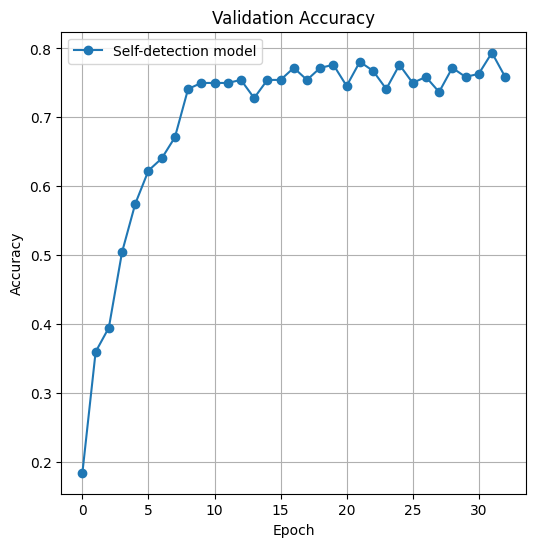

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create dataset
# X, y = generate_labeled_dataset()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize DBN
dbn = DBN(input_size=X_train_tensor.shape[1], layers=[72, 2*72-1,2*72-1], mode='none', k=5)
dbn.train_DBN(X_train_tensor)

# Create a classification model
model = dbn.initialize_model()
# Append final classification layer
# model.add_module("second_final_layer", nn.Linear(dbn.layers[-1], 5))
model.add_module("final_layer", nn.Linear(dbn.layers[-1], 5))  # 5 classes
# model.add_module("softmax", nn.Softmax(dim=1))

# Train the classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
accuracies_selfdetect= []
# Training loop
num_epochs = 801
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if(epoch%25 == 0):
        with torch.no_grad():
            model.eval()
            y_pred = model(X_val_tensor)
            y_pred = F.softmax(y_pred,dim=1)
            y_pred_classes = y_pred.argmax(dim=1)
            accuracy = accuracy_score(y_val_tensor.numpy(), y_pred_classes.numpy())
            accuracies_selfdetect.append(accuracy)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, Accuracy:{accuracy:.4f} ")

# Evaluate the model
epochs_ = len(accuracies_selfdetect)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.plot( range(0, epochs_), accuracies_selfdetect, marker='o', label='Self-detection model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = F.softmax(y_pred,dim=1)
    y_pred_classes = y_pred.argmax(dim=1)
accuracy = accuracy_score(y_test_tensor.numpy(), y_pred_classes.numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 59.39%


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [64]:
f1 = f1_score(y_test_tensor.numpy(), y_pred_classes.numpy(), average='weighted')

In [66]:
report = classification_report(y_test_tensor.numpy(), y_pred_classes.numpy(), digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.766     0.900     0.828        40
           1      0.660     0.733     0.695        45
           2      0.711     0.593     0.646        54
           3      0.897     0.795     0.843        44
           4      0.688     0.717     0.702        46

    accuracy                          0.738       229
   macro avg      0.744     0.748     0.743       229
weighted avg      0.742     0.738     0.737       229



In [1]:
rnn_data = [
    (0, 0.1974), (25, 0.3158), (50, 0.5307), (75, 0.6184), (100, 0.6623),
    (125, 0.7105), (150, 0.7763), (175, 0.7807), (200, 0.7851), (225, 0.7939),
    (250, 0.7939), (275, 0.8289), (300, 0.8333), (325, 0.8246), (350, 0.8246),
    (375, 0.8421), (400, 0.8421), (425, 0.8553), (450, 0.8421), (475, 0.8596),
    (500, 0.8640), (525, 0.8509), (550, 0.8509), (575, 0.8640), (600, 0.8640),
    (625, 0.8333), (650, 0.8114), (675, 0.8465), (700, 0.8596), (725, 0.8509),
    (750, 0.8333), (775, 0.8289), (800, 0.8289)
]

gru_data = [
    (0, 0.2018), (25, 0.5044), (50, 0.8070), (75, 0.8289), (100, 0.8333),
    (125, 0.8553), (150, 0.8553), (175, 0.8860), (200, 0.8816), (225, 0.8728),
    (250, 0.8860), (275, 0.8816), (300, 0.8904), (325, 0.8860), (350, 0.8904),
    (375, 0.8860), (400, 0.8816), (425, 0.8816), (450, 0.8816), (475, 0.8860),
    (500, 0.8991), (525, 0.8772), (550, 0.8947), (575, 0.8860), (600, 0.9035),
    (625, 0.9123), (650, 0.9035), (675, 0.9035), (700, 0.9079), (725, 0.9079),
    (750, 0.9123), (775, 0.9123), (800, 0.9123)
]

lstm_data = [
    (0, 0.1842), (25, 0.3860), (50, 0.8728), (75, 0.9342), (100, 0.9518),
    (125, 0.9342), (150, 0.9298), (175, 0.9254), (200, 0.9561), (225, 0.9649),
    (250, 0.9649), (275, 0.9649), (300, 0.9649), (325, 0.9649), (350, 0.9649),
    (375, 0.9649), (400, 0.9649), (425, 0.9649), (450, 0.9649), (475, 0.9605),
    (500, 0.9605), (525, 0.9605), (550, 0.9605), (575, 0.9561), (600, 0.9561),
    (625, 0.9561), (650, 0.9518), (675, 0.9518), (700, 0.9518), (725, 0.9518),
    (750, 0.9518), (775, 0.9518), (800, 0.9518)
]

paper_model = [
    (0, 0.1491), (25, 0.3553), (50, 0.3289), (75, 0.4912), (100, 0.5482),
    (125, 0.5921), (150, 0.6623), (175, 0.6754), (200, 0.6798), (225, 0.7018),
    (250, 0.7149), (275, 0.7368), (300, 0.7412), (325, 0.7500), (350, 0.7149),
    (375, 0.6754), (400, 0.7456), (425, 0.7675), (450, 0.7719), (475, 0.7807),
    (500, 0.7500), (525, 0.7982), (550, 0.7763), (575, 0.7982), (600, 0.7939),
    (625, 0.7895), (650, 0.8026), (675, 0.7982), (700, 0.7851), (725, 0.7982),
    (750, 0.7895), (775, 0.7939), (800, 0.8026)
]

def unpack_data(data):
    return zip(*data)

rnn_x, rnn_y = unpack_data(rnn_data)
gru_x, gru_y = unpack_data(gru_data)
lstm_x, lstm_y = unpack_data(lstm_data)
paper_x, paper_y = unpack_data(paper_model)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rnn_x, rnn_y, label='RNN', marker='o')
plt.plot(gru_x, gru_y, label='GRU', marker='s')
plt.plot(lstm_x, lstm_y, label='LSTM', marker='^')
plt.plot(paper_x, paper_y, label='DBN', marker='d')

plt.title('Model Performance Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined